In [3]:
import time
kernel_start_time = time.perf_counter()
import numpy as np 
import pandas as pd 
from IPython.display import SVG, display
import os, time, glob, shutil
starttime = time.time()

import warnings
warnings.simplefilter("ignore")
from pathlib import Path
import xml.etree.ElementTree as ET 
from PIL import Image 
import glob
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

from argparse import Namespace
import numpy as np
import random
import torch
from torch import nn, optim
import torch.nn.functional as F

import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image
import torchvision.utils as vutils

from ignite.contrib.handlers import ProgressBar
from ignite.engine import Engine, Events
from ignite.handlers import ModelCheckpoint, Timer
from ignite.metrics import RunningAverage

In [4]:
args = Namespace(
    seed=123,
    disable_cuda=False,
    device=None,
    debug=False,
    num_workers=4,
    CKPT_PREFIX = 'sagan_hinge_loss',
    exp_name = None,

    PRINT_FREQ = 600,
    FAKE_IMG_FNAME = 'fake_sample_epoch_{:04d}.png',
    REAL_IMG_FNAME = 'real_sample_epoch_{:04d}.png',
    LOGS_FNAME = 'logs.tsv',
    PLOT_FNAME = 'plot.svg',
    SAMPLES_FNAME = 'samples.svg',
    output_dir = '../output_dir/',
    alpha = 0.98, 

    shuffle=True,
    datapath=Path('../input/all-dogs/all-dogs/'),
    root_images=Path("../input/all-dogs/all-dogs"),
    root_annots=Path("../input/annotation/Annotation/"),

    num_epochs=500,
    lrD=4e-4,
    lrG=1e-4,
    beta1 = 0., 
    beta2 = 0.9,
    batch_size=32,
    weight_decay=0.001,
    log_interval=100,
    num_disc_update=1,

    num_classes=120,
    image_size=64,
    in_channels=3,
    num_feature_maps_gen=64,
    num_feature_maps_disc=64,
    latent_dim=128,
    input_dim=64*64,
    hidden_size=400,    
    dropout_p=0.2,
)
args.exp_name = args.CKPT_PREFIX + f"_{args.num_epochs}ep_{args.batch_size}bs_{args.num_disc_update}ndisc"
print("="*100)
print(args.exp_name)
print("="*100)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def seed_everything(seed=args.seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

sagan_hinge_loss_500ep_32bs_1ndisc


In [5]:
def get_bbox(img_path):
    annotation_basename = os.path.splitext(os.path.basename(img_path))[0]
    annotation_dirname = next(dirname for dirname in os.listdir(args.root_annots) if dirname.startswith(annotation_basename.split('_')[0]))
    annotation_filename = os.path.join(args.root_annots, annotation_dirname, annotation_basename)
    tree = ET.parse(annotation_filename)
    root = tree.getroot()
    objects = root.findall('object')
    bboxes = []
    for o in objects:
        bndbox = o.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        w = np.min((xmax - xmin, ymax - ymin))
        bboxes.append((xmin, ymin, xmin+w, ymin+w))
    return bboxes

def doggo_loader(img_path):
    img = torchvision.datasets.folder.default_loader(img_path) # default loader
    bbox = get_bbox(img_path)[-1]
    return img.crop(bbox)

def clear_output_dir():
    try:
        shutil.rmtree(args.output_dir)
    except FileNotFoundError:
        pass

def check_gen_samples(dataloader, img_list):
    real_batch = next(iter(dataloader))
    plt.figure(figsize=(15,15))
    plt.subplot(1,2,1)
    plt.axis("off")
    plt.title("Real Images")
    plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))
    plt.subplot(1,2,2)
    plt.axis("off")
    plt.title("Fake Images")
    plt.imshow(np.transpose(img_list[-1],(1,2,0)))
    plt.show()
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [6]:
class DogDataset(Dataset):
    def __init__(self, img_dir, transform1, transform2=None):
        self.img_dir = img_dir
        self.img_names = os.listdir(img_dir)
        self.transform1 = transform1
        self.transform2 = transform2
        
        self.imgs = []
        self.labels = []
        for img_name in tqdm(self.img_names):
            img_path = os.path.join(img_dir, img_name)
            img = Image.open(img_path)
            annotation_basename = os.path.splitext(os.path.basename(img_path))[0]
            annotation_dirname = next(dirname for dirname in os.listdir(args.root_annots) if dirname.startswith(annotation_basename.split('_')[0]))
            annotation_filename = os.path.join(args.root_annots, annotation_dirname, annotation_basename)
            tree = ET.parse(annotation_filename)
            root = tree.getroot()
            objects = root.findall('object')
            bboxes = []
            for o in objects:
                bndbox = o.find('bndbox')
                xmin = int(bndbox.find('xmin').text)
                ymin = int(bndbox.find('ymin').text)
                xmax = int(bndbox.find('xmax').text)
                ymax = int(bndbox.find('ymax').text)
                w = np.min((xmax - xmin, ymax - ymin))
                bbox = (xmin, ymin, xmin+w, ymin+w)
                img_crop = img.crop(bbox)
                
                self.imgs.append(self.transform1(img_crop))
                self.labels.append(annotation_dirname.split('-')[1].lower())
                
    def __getitem__(self, index):
        img = self.imgs[index]
        label = self.labels[index]
        
        if self.transform2 is not None:
            img = self.transform2(img)
        
        return img, label

    def __len__(self):
        return len(self.imgs)

def get_transforms():
    normalize = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    random_transforms = [transforms.ColorJitter(), 
                         transforms.RandomRotation(degrees=1)]
    random_cropper = [torchvision.transforms.CenterCrop(args.image_size), torchvision.transforms.RandomCrop(args.image_size)]
    transform1 = transforms.Compose([
        transforms.Resize(args.image_size),
        transforms.CenterCrop(args.image_size),
    ])

    transform2 = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomApply(random_transforms, p=0.3),
        transforms.ToTensor(),
        normalize]) 
    
    return transform1, transform2

transform1, transform2 = get_transforms()
train_data = DogDataset(img_dir=args.root_images,
                        transform1=transform1,
                        transform2=transform2)

decoded_dog_labels = {i:breed for i, breed in enumerate(sorted(set(train_data.labels)))}
encoded_dog_labels = {breed:i for i, breed in enumerate(sorted(set(train_data.labels)))}
train_data.labels = [encoded_dog_labels[l] for l in train_data.labels] # encode dog labels in the data generator
dataloader = torch.utils.data.DataLoader(train_data, 
                                         shuffle=True,
                                         batch_size=args.batch_size, 
                                         num_workers=args.num_workers)

100%|██████████| 20579/20579 [02:44<00:00, 124.88it/s]


In [7]:
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.)

def snconv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True):
    return nn.utils.spectral_norm(nn.Conv2d(in_channels=in_channels, 
                                            out_channels=out_channels, 
                                            kernel_size=kernel_size,
                                            stride=stride, 
                                            padding=padding, 
                                            dilation=dilation, 
                                            groups=groups, 
                                            bias=bias))

def snlinear(in_features, out_features):
    return nn.utils.spectral_norm(nn.Linear(in_features=in_features, out_features=out_features))

def sn_embedding(num_embeddings, embedding_dim):
    return nn.utils.spectral_norm(nn.Embedding(num_embeddings=num_embeddings, embedding_dim=embedding_dim))

class PixelwiseNorm(nn.Module):
    def __init__(self):
        super(PixelwiseNorm, self).__init__()

    def forward(self, x, alpha=1e-8):
        y = x.pow(2.).mean(dim=1, keepdim=True).add(alpha).sqrt()  # [N1HW]
        y = x / y 
        return y
    
class MinibatchStdDev(nn.Module):
    def __init__(self):
        super(MinibatchStdDev, self).__init__()

    def forward(self, x, alpha=1e-8):
        batch_size, _, height, width = x.shape
        y = x - x.mean(dim=0, keepdim=True)
        y = torch.sqrt(y.pow(2.).mean(dim=0, keepdim=False) + alpha)
        y = y.mean().view(1, 1, 1, 1)
        y = y.repeat(batch_size,1, height, width)
        y = torch.cat([x, y], 1)
        return y    
    
class GaussianNoise(nn.Module):
    def __init__(self, sigma=0.1, is_relative_detach=True):
        super().__init__()
        self.sigma = sigma
        self.is_relative_detach = is_relative_detach
        self.noise = torch.tensor(0.).to(device)

    def forward(self, x):
        if self.training and self.sigma != 0:
            scale = self.sigma * x.detach() if self.is_relative_detach else self.sigma * x
            sampled_noise = self.noise.repeat(*x.size()).normal_() * scale
            x = x + sampled_noise
        return x 

class ConditionalBatchNorm2d(nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()
        self.num_features = num_features
        self.bn = nn.BatchNorm2d(num_features)
        self.embed = nn.Embedding(num_classes, num_features * 2)
        self.embed.weight.data[:, :num_features].fill_(1.)  # Initialize scale to 1
        self.embed.weight.data[:, num_features:].zero_()    # Initialize bias at 0

    def forward(self, x, y):
        out = self.bn(x)
        gamma, beta = self.embed(y).chunk(2, 1)
        out = gamma.view(-1, self.num_features, 1, 1) * out + beta.view(-1, self.num_features, 1, 1)
        return out    

class Self_Attn(nn.Module):
    def __init__(self, in_channels):
        super(Self_Attn, self).__init__()
        self.in_channels = in_channels
        self.snconv1x1_theta = snconv2d(in_channels=in_channels, 
                                        out_channels=in_channels//8, 
                                        kernel_size=1, stride=1, padding=0)
        self.snconv1x1_phi = snconv2d(in_channels=in_channels, 
                                      out_channels=in_channels//8, 
                                      kernel_size=1, stride=1, padding=0)
        self.snconv1x1_g = snconv2d(in_channels=in_channels, 
                                    out_channels=in_channels//2, 
                                    kernel_size=1, stride=1, padding=0)
        self.snconv1x1_attn = snconv2d(in_channels=in_channels//2, 
                                       out_channels=in_channels, 
                                       kernel_size=1, stride=1, padding=0)
        self.maxpool = nn.MaxPool2d(2, stride=2, padding=0)
        self.softmax  = nn.Softmax(dim=-1)
        self.sigma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        _, ch, h, w = x.size()
        theta = self.snconv1x1_theta(x)
        theta = theta.view(-1, ch//8, h*w)
        phi = self.snconv1x1_phi(x)
        phi = self.maxpool(phi)
        phi = phi.view(-1, ch//8, h*w//4)

        attn = torch.bmm(theta.permute(0, 2, 1), phi)
        attn = self.softmax(attn)

        g = self.snconv1x1_g(x)
        g = self.maxpool(g)
        g = g.view(-1, ch//2, h*w//4)

        attn_g = torch.bmm(g, attn.permute(0, 2, 1))
        attn_g = attn_g.view(-1, ch//2, h, w)
        attn_g = self.snconv1x1_attn(attn_g)

        out = x + self.sigma*attn_g
        return out      

In [8]:
class GenBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_classes):
        super(GenBlock, self).__init__()
        self.cond_bn1 = ConditionalBatchNorm2d(in_channels, num_classes)
        self.relu = nn.ReLU(inplace=True)
        self.ps1 = nn.PixelShuffle(2)
        self.snconv2d1 = snconv2d(in_channels=in_channels//4, out_channels=out_channels, 
                                  kernel_size=3, stride=1, padding=1)
        self.cond_bn2 = ConditionalBatchNorm2d(out_channels, num_classes)
        self.snconv2d2 = snconv2d(in_channels=out_channels, out_channels=out_channels, 
                                  kernel_size=3, stride=1, padding=1)
        self.snconv2d0 = snconv2d(in_channels=in_channels//4, out_channels=out_channels, 
                                  kernel_size=1, stride=1, padding=0)
    def forward(self, x, labels):
        x0 = x        
        x = self.cond_bn1(x, labels)
        x = self.relu(x)
        x = self.ps1(x)
        x = self.snconv2d1(x)
        x = self.cond_bn2(x, labels)
        x = self.relu(x)
        x = self.snconv2d2(x)

        x0 = self.ps1(x0)
        x0 = self.snconv2d0(x0)
        out = x + x0
        return out
    
class DiscOptBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DiscOptBlock, self).__init__()
        self.snconv2d1 = snconv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.snconv2d2 = snconv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1)
        self.downsample = nn.AvgPool2d(2)
        self.snconv2d0 = snconv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        x0 = x

        x = self.snconv2d1(x)
        x = self.relu(x)
        x = self.snconv2d2(x)
        x = self.downsample(x)

        x0 = self.downsample(x0)
        x0 = self.snconv2d0(x0)

        out = x + x0
        return out

class DiscBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DiscBlock, self).__init__()
        self.relu = nn.LeakyReLU(0.2, inplace=True)
        self.snconv2d1 = snconv2d(in_channels=in_channels, 
                                  out_channels=out_channels, 
                                  kernel_size=3, stride=1, padding=1)
        self.snconv2d2 = snconv2d(in_channels=out_channels, 
                                  out_channels=out_channels, 
                                  kernel_size=3, stride=1, padding=1)
        self.downsample = nn.AvgPool2d(2)
        self.ch_mismatch = False
        if in_channels != out_channels:
            self.ch_mismatch = True
        self.snconv2d0 = snconv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=1, padding=0)

    def forward(self, x, downsample=True):
        x0 = x

        x = self.relu(x)
        x = self.snconv2d1(x)
        x = self.relu(x)
        if downsample:
            x = self.downsample(x)

        if downsample or self.ch_mismatch:
            x0 = self.snconv2d0(x0)
            if downsample:
                x0 = self.downsample(x0)

        out = x + x0
        return out
    
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.z_dim = args.latent_dim
        self.g_conv_dim = args.num_feature_maps_gen
        
        self.snlinear0 = snlinear(in_features=self.z_dim, out_features=self.g_conv_dim*8*4*4)
        self.block1 = GenBlock(self.g_conv_dim*8, self.g_conv_dim*8, args.num_classes)
        self.block2 = GenBlock(self.g_conv_dim*8, self.g_conv_dim*4, args.num_classes)
        self.block3 = GenBlock(self.g_conv_dim*4, self.g_conv_dim*2, args.num_classes)
        self.self_attn = Self_Attn(self.g_conv_dim*2)
        self.block4 = GenBlock(self.g_conv_dim*2, self.g_conv_dim, args.num_classes)
        self.bn = nn.BatchNorm2d(self.g_conv_dim, eps=1e-5, momentum=0.0001, affine=True)
        self.relu = nn.ReLU(inplace=True)
        self.snconv2d1 = snconv2d(in_channels=self.g_conv_dim, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.tanh = nn.Tanh()
        self.apply(init_weights)

    def forward(self, z, labels):
        act0 = self.snlinear0(z)           
        act0 = act0.view(-1, self.g_conv_dim*8, 4, 4) 
        act1 = self.block1(act0, labels)   
        act2 = self.block2(act1, labels)  
        act3 = self.block3(act2, labels)   
        act3 = self.self_attn(act3)        
        act4 = self.block4(act3, labels)               
        act6 = self.snconv2d1(act4)        
        act6 = self.tanh(act6)              
        return act6
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.d_conv_dim = args.num_feature_maps_disc
        self.opt_block1 = DiscOptBlock(3, self.d_conv_dim)
        self.block1 = DiscBlock(self.d_conv_dim, self.d_conv_dim*2)
        self.self_attn = Self_Attn(self.d_conv_dim*2)
        self.block2 = DiscBlock(self.d_conv_dim*2, self.d_conv_dim*4)
        self.block3 = DiscBlock(self.d_conv_dim*4, self.d_conv_dim*4)
        self.block4 = DiscBlock(self.d_conv_dim*4, self.d_conv_dim*8)
        self.block5 = DiscBlock(self.d_conv_dim*8, self.d_conv_dim*8)
        self.relu = nn.ReLU(inplace=True)
        self.snlinear1 = snlinear(in_features=self.d_conv_dim*8, out_features=1)
        self.sn_embedding1 = sn_embedding(args.num_classes, self.d_conv_dim*8)
        self.apply(init_weights)
        nn.init.xavier_uniform_(self.sn_embedding1.weight)

    def forward(self, x, labels):
        h0 = self.opt_block1(x) 
        h1 = self.block1(h0)    
        h1 = self.self_attn(h1) 
        h2 = self.block2(h1)    
        h3 = self.block3(h2)    
        h4 = self.block4(h3)    
        h5 = self.block5(h4, downsample=False)  
        h5 = self.relu(h5)             
        h6 = torch.sum(h5, dim=[2,3])  
        output1 = torch.squeeze(self.snlinear1(h6))
        h_labels = self.sn_embedding1(labels)  
        proj = torch.mul(h6, h_labels)         
        output2 = torch.sum(proj, dim=[1]) 
        output = output1 + output2              
        return output    

In [9]:
netG = Generator().to(device)
netD = Discriminator().to(device)

weights_init(netG)
weights_init(netD)
print("Generator parameters:    ", sum(p.numel() for p in netG.parameters() if p.requires_grad))
print("Discriminator parameters:", sum(p.numel() for p in netD.parameters() if p.requires_grad))

fixed_noise = torch.randn(64, args.latent_dim, device=device)
dog_labels = torch.randint(0, len(encoded_dog_labels), (64, ), device=device)

real_label = 0.9
fake_label = 0.0

BCE_stable = nn.BCEWithLogitsLoss()
optimizerD = optim.Adam(netD.parameters(), lr=args.lrD, betas=(args.beta1, args.beta2))
optimizerG = optim.Adam(netG.parameters(), lr=args.lrG, betas=(args.beta1, args.beta2))

def step(engine, batch):
    def train_D(images, labels):
        noise = torch.randn(args.batch_size, args.latent_dim, device=device)
        G_output = netG(noise, labels)

        Dx_score = netD(images, labels) # D(x)
        DG_score = netD(G_output, labels) # D(G(z))

        D_loss = (torch.mean(torch.nn.ReLU()(1.0 - (Dx_score - torch.mean(DG_score)))) + 
                  torch.mean(torch.nn.ReLU()(1.0 + (DG_score - torch.mean(Dx_score)))))/2

        return D_loss, F.sigmoid(Dx_score).mean().item(), F.sigmoid(DG_score).mean().item()
    
    def train_G(images, labels):

        noise = torch.randn(args.batch_size, args.latent_dim, device=device)
        G_output = netG(noise, labels) 
        Dx_score = netD(images, labels) 
        DG_score = netD(G_output, labels) 
               
        G_loss = (torch.mean(torch.nn.ReLU()(1.0 + (Dx_score - torch.mean(DG_score)))) + 
                  torch.mean(torch.nn.ReLU()(1.0 - (DG_score - torch.mean(Dx_score)))))/2

        return G_loss, F.sigmoid(DG_score).mean().item()
    
    images, labels = batch[0].to(device), batch[1].to(device)
    args.batch_size = images.size(0)
    D_step_loss = []
    for _ in range(args.num_disc_update):
        netD.zero_grad()
        
        D_loss, Dx_score, DG_score1 = train_D(images, labels)
        D_loss.backward()
        optimizerD.step()
        D_step_loss.append(D_loss.item())

    netG.zero_grad()

    G_loss, DG_score2 = train_G(images, labels)
    G_loss.backward()
    optimizerG.step()
        
    return {
            'D_loss': np.mean(D_step_loss),
            'G_loss': G_loss.item(),
            'Dx_score': Dx_score,
            'DG_score1': DG_score1,
            'DG_score2': DG_score2
    }    

Generator parameters:     5874148
Discriminator parameters: 11169442


In [10]:
clear_output_dir()
trainer = Engine(step)
checkpoint_handler = ModelCheckpoint(args.output_dir, 
                                     args.CKPT_PREFIX, 
                                     save_interval=1, 
                                     n_saved=10, 
                                     require_empty=False)
timer = Timer(average=True)
monitoring_metrics = ['D_loss', 'G_loss', 'Dx_score', 'DG_score1', 'DG_score2']
RunningAverage(alpha=args.alpha, output_transform=lambda x: x['D_loss']).attach(trainer, 'D_loss')
RunningAverage(alpha=args.alpha, output_transform=lambda x: x['G_loss']).attach(trainer, 'G_loss')
RunningAverage(alpha=args.alpha, output_transform=lambda x: x['Dx_score']).attach(trainer, 'Dx_score')
RunningAverage(alpha=args.alpha, output_transform=lambda x: x['DG_score1']).attach(trainer, 'DG_score1')
RunningAverage(alpha=args.alpha, output_transform=lambda x: x['DG_score2']).attach(trainer, 'DG_score2')

pbar = ProgressBar()
pbar.attach(trainer, metric_names=monitoring_metrics)

@trainer.on(Events.ITERATION_COMPLETED)
def print_logs(engine):
    if (engine.state.iteration - 1) % args.PRINT_FREQ == 0:
        fname = os.path.join(args.output_dir, args.LOGS_FNAME)
        columns = ["iteration", ] + list(engine.state.metrics.keys())
        values = [str(engine.state.iteration), ] + \
                 [str(round(value, 5)) for value in engine.state.metrics.values()]
        with open(fname, 'a') as f:
            if f.tell() == 0:
                print('\t'.join(columns), file=f)
            print('\t'.join(values), file=f)

        message = '[{epoch}/{max_epoch}][{i}/{max_i}]'.format(epoch=engine.state.epoch,
                                                              max_epoch=args.num_epochs,
                                                              i=(engine.state.iteration % len(dataloader)),
                                                              max_i=len(dataloader))
        for name, value in zip(columns, values):
            message += ' | {name}: {value}'.format(name=name, value=value)
        pbar.log_message(message)

@trainer.on(Events.EPOCH_COMPLETED)
def save_fake_example(engine):
    fake = netG(fixed_noise, dog_labels).detach().cpu()
    path = os.path.join(args.output_dir, args.FAKE_IMG_FNAME.format(engine.state.epoch))
    vutils.save_image((fake+1.)/2., path, normalize=True)
    
@trainer.on(Events.EPOCH_COMPLETED)
def save_real_example(engine):
    img, _ = engine.state.batch
    path = os.path.join(args.output_dir, args.REAL_IMG_FNAME.format(engine.state.epoch))
    vutils.save_image(img, path, normalize=True)

@trainer.on(Events.EPOCH_COMPLETED)
def display_images(engine):
    if engine.state.epoch % 10 == 0:
        display(Image.open(os.path.join(args.output_dir, args.REAL_IMG_FNAME.format(engine.state.epoch))))
        display(Image.open(os.path.join(args.output_dir, args.FAKE_IMG_FNAME.format(engine.state.epoch))))    

trainer.add_event_handler(event_name=Events.EPOCH_COMPLETED, 
                          handler=checkpoint_handler,
                          to_save={
                              'netG': netG,
                              'netD': netD
                          })

timer.attach(trainer, 
             start=Events.EPOCH_STARTED, 
             resume=Events.EPOCH_STARTED,
             pause=Events.EPOCH_COMPLETED, 
             step=Events.EPOCH_COMPLETED)

@trainer.on(Events.EPOCH_COMPLETED)
def print_times(engine):
    pbar.log_message(f'Epoch {engine.state.epoch} done. Time per epoch: {timer.value()/60:.3f}[min]')
    timer.reset()
    
@trainer.on(Events.EPOCH_COMPLETED)
def create_plots(engine):
    try:
        import matplotlib as mpl
        mpl.use('agg')

        import numpy as np
        import pandas as pd
        import matplotlib.pyplot as plt

    except ImportError:
        warnings.warn('Loss plots will not be generated -- pandas or matplotlib not found')

    else:
        df = pd.read_csv(os.path.join(args.output_dir, args.LOGS_FNAME), delimiter='\t', index_col='iteration')
        _ = df.loc[:, list(engine.state.metrics.keys())].plot(subplots=True, figsize=(10, 10))
        _ = plt.xlabel('Iteration number')
        fig = plt.gcf()
        path = os.path.join(args.output_dir, args.PLOT_FNAME)
        fig.savefig(path)
        
@trainer.on(Events.EPOCH_STARTED)
def handle_timeout(engine):
    if time.perf_counter() - kernel_start_time > 31000:
        print("Time limit reached! Stopping kernel!")
        engine.terminate()

        create_plots(engine)
        checkpoint_handler(engine, {
            'netG_exception': netG,
            'netD_exception': netD
        })
        
@trainer.on(Events.EXCEPTION_RAISED)
def handle_exception(engine, e):
    if isinstance(e, KeyboardInterrupt) and (engine.state.iteration > 1):
        engine.terminate()
        warnings.warn('KeyboardInterrupt caught. Exiting gracefully.')

        create_plots(engine)
        checkpoint_handler(engine, {
            'netG_exception': netG,
            'netD_exception': netD
        })

    else:
        raise e
        
trainer.run(dataloader, args.num_epochs)

[1/500][1/692] | iteration: 1 | D_loss: 1.1517 | G_loss: 1.74259 | Dx_score: 0.44588 | DG_score1: 0.48308 | DG_score2: 0.58261
[1/500][601/692] | iteration: 601 | D_loss: 0.43185 | G_loss: 3.49819 | Dx_score: 0.57139 | DG_score1: 0.43396 | DG_score2: 0.33646
Epoch 1 done. Time per epoch: 3.293[min]


[2/500][509/692] | iteration: 1201 | D_loss: 0.64249 | G_loss: 2.67871 | Dx_score: 0.46645 | DG_score1: 0.38395 | DG_score2: 0.29186
Epoch 2 done. Time per epoch: 3.303[min]


[3/500][417/692] | iteration: 1801 | D_loss: 0.70485 | G_loss: 2.34133 | Dx_score: 0.79552 | DG_score1: 0.74532 | DG_score2: 0.69009
Epoch 3 done. Time per epoch: 3.302[min]


[4/500][325/692] | iteration: 2401 | D_loss: 0.61501 | G_loss: 2.50748 | Dx_score: 0.78448 | DG_score1: 0.71478 | DG_score2: 0.64563
Epoch 4 done. Time per epoch: 3.294[min]


[5/500][233/692] | iteration: 3001 | D_loss: 0.54561 | G_loss: 2.61776 | Dx_score: 0.75579 | DG_score1: 0.66006 | DG_score2: 0.59834
Epoch 5 done. Time per epoch: 3.301[min]


[6/500][141/692] | iteration: 3601 | D_loss: 0.59913 | G_loss: 2.48833 | Dx_score: 0.69592 | DG_score1: 0.60922 | DG_score2: 0.51234
Epoch 6 done. Time per epoch: 3.309[min]


[7/500][49/692] | iteration: 4201 | D_loss: 0.66461 | G_loss: 2.23696 | Dx_score: 0.7083 | DG_score1: 0.63529 | DG_score2: 0.55356
[7/500][649/692] | iteration: 4801 | D_loss: 0.7313 | G_loss: 2.22644 | Dx_score: 0.51962 | DG_score1: 0.4496 | DG_score2: 0.39208
Epoch 7 done. Time per epoch: 3.298[min]


[8/500][557/692] | iteration: 5401 | D_loss: 0.73653 | G_loss: 2.06937 | Dx_score: 0.44747 | DG_score1: 0.37649 | DG_score2: 0.3221
Epoch 8 done. Time per epoch: 3.299[min]


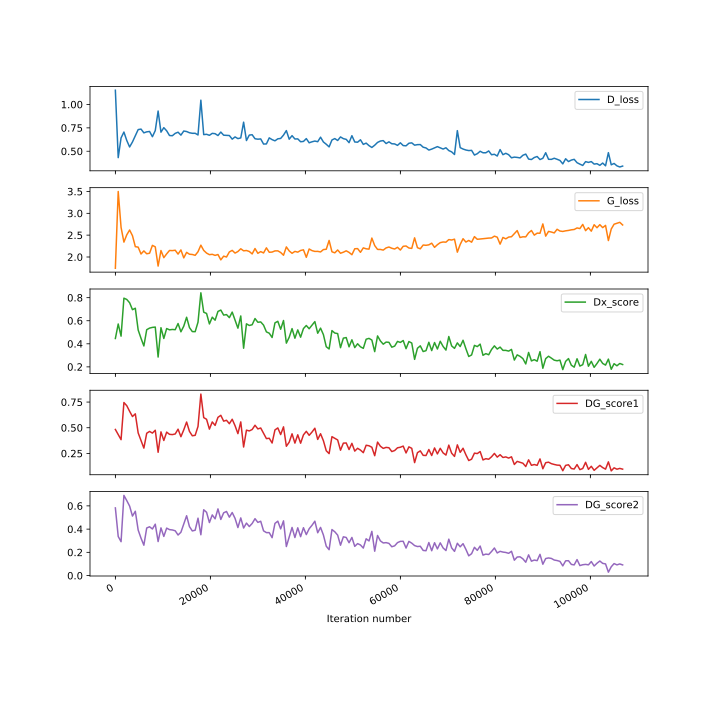

In [11]:
display(SVG("../output_dir/plot.svg"))

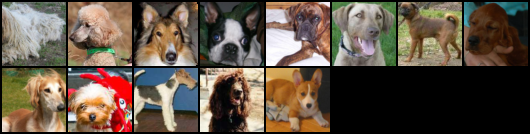

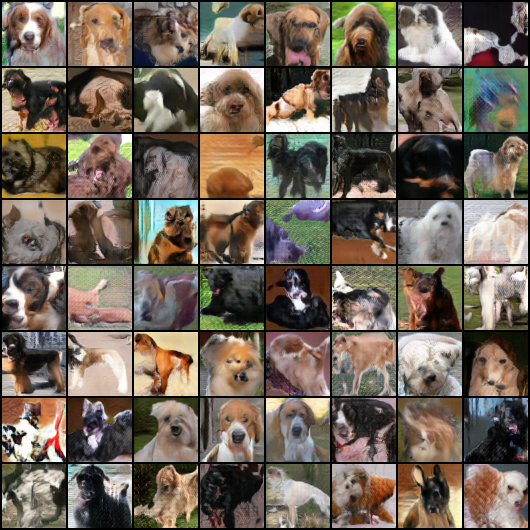

In [12]:
display(Image.open(os.path.join(args.output_dir, args.REAL_IMG_FNAME.format(trainer.state.epoch-1))))
display(Image.open(os.path.join(args.output_dir, args.FAKE_IMG_FNAME.format(trainer.state.epoch-1))))

In [13]:
def mse(imageA, imageB):
        err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
        err /= float(imageA.shape[0] * imageA.shape[1])
        return err

def analyse_generated_by_class(n_images=5):
    good_breeds = []
    for l in range(len(decoded_dog_labels)):
        sample = []
        for _ in range(n_images):
            noise = torch.randn(1, args.latent_dim, device=device)
            dog_label = torch.full((1,) , l, device=device, dtype=torch.long)
            gen_image = netG(noise, dog_label).to("cpu").clone().detach().squeeze(0)
            gen_image = gen_image.numpy().transpose(1, 2, 0)
            sample.append(gen_image)

        d = np.round(np.sum([mse(sample[k], sample[k+1]) for k in range(len(sample)-1)])/n_images, 1)
        if d < 1.0: continue  
            
        print(f"Generated breed({d}): ", decoded_dog_labels[l])
        l_noise = torch.randn(n_images, args.latent_dim, device=device)
        l_labels = torch.randint(0, len(encoded_dog_labels), (n_images, ), device=device)
            
        fake = netG(l_noise, l_labels).detach().cpu()
        path = os.path.join(args.output_dir, f'img_{l}.png')
        vutils.save_image((fake+1.)/2., path, normalize=True)
        display(Image.open(os.path.join(args.output_dir, f'img_{l}.png')))    
        
        good_breeds.append(l)
    return good_breeds

In [14]:
from scipy.stats import truncnorm

def truncated_normal(size, threshold=1):
    values = truncnorm.rvs(-threshold, threshold, size=size)
    return values

def create_submit(good_breeds):
    print("Creating submit")
    os.makedirs('../output_images', exist_ok=True)
    im_batch_size = 50
    n_images = 10000
    
    all_dog_labels = np.random.choice(good_breeds, size=n_images, replace=True)
    for i_batch in range(0, n_images, im_batch_size):
        noise = torch.randn(im_batch_size, args.latent_dim, device=device)
        dog_labels = torch.from_numpy(all_dog_labels[i_batch: (i_batch+im_batch_size)]).to(device)
        gen_images = netG(noise, dog_labels)
        gen_images = (gen_images.to("cpu").clone().detach() + 1) / 2
        for ii, img in enumerate(gen_images):
            save_image(gen_images[ii, :, :, :], os.path.join('../output_images', f'image_{i_batch + ii:05d}.png'))
            
    import shutil
    shutil.make_archive('images', 'zip', '../output_images')

Generated breed(1.1):  affenpinscher


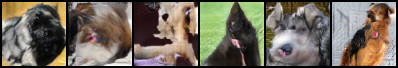

Generated breed(1.0):  airedale


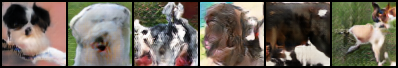

Generated breed(1.0):  american_staffordshire_terrier


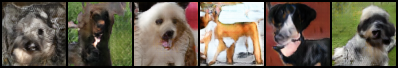

Generated breed(1.1):  appenzeller


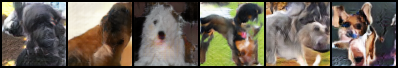

Generated breed(1.0):  basenji


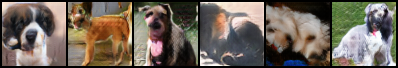

Generated breed(1.1):  basset


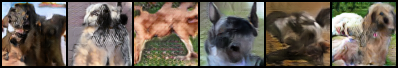

Generated breed(1.1):  beagle


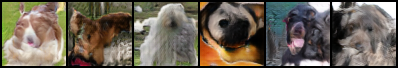

Generated breed(1.0):  bedlington_terrier


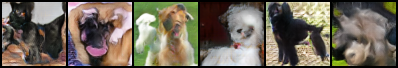

Generated breed(1.1):  bernese_mountain_dog


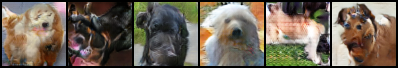

Generated breed(1.0):  bluetick


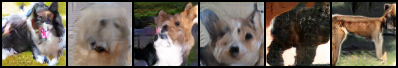

Generated breed(1.0):  border_collie


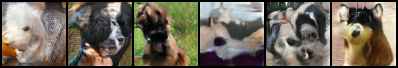

Generated breed(1.0):  borzoi


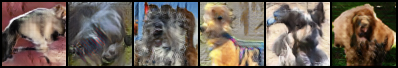

Generated breed(1.1):  boston_bull


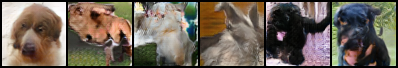

Generated breed(1.0):  boxer


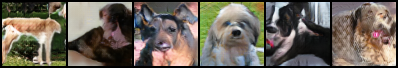

Generated breed(1.1):  brabancon_griffon


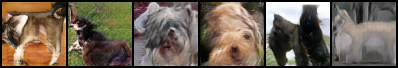

Generated breed(1.0):  briard


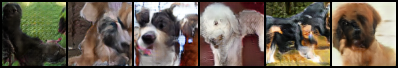

Generated breed(1.2):  brittany_spaniel


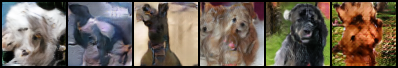

Generated breed(1.0):  bull_mastiff


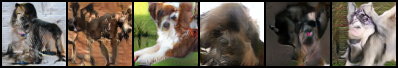

Generated breed(1.1):  cardigan


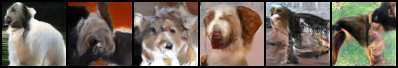

Generated breed(1.0):  chihuahua


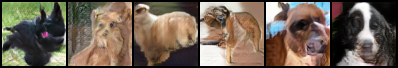

Generated breed(1.0):  clumber


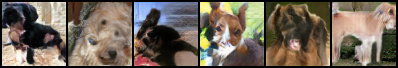

Generated breed(1.1):  collie


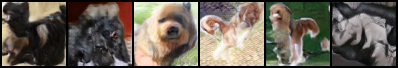

Generated breed(1.1):  curly


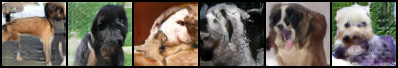

Generated breed(1.0):  doberman


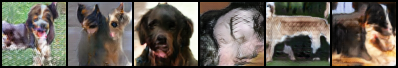

Generated breed(1.0):  english_springer


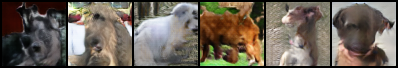

Generated breed(1.0):  entlebucher


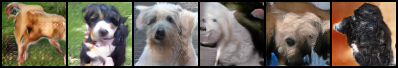

Generated breed(1.0):  eskimo_dog


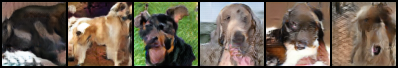

Generated breed(1.0):  flat


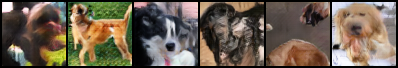

Generated breed(1.2):  french_bulldog


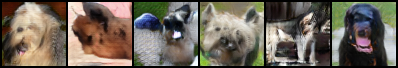

Generated breed(1.2):  german_shepherd


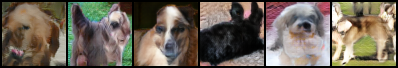

Generated breed(1.0):  german_short


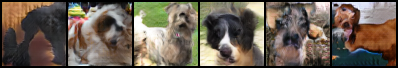

Generated breed(1.0):  giant_schnauzer


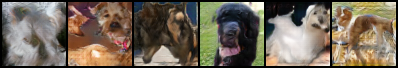

Generated breed(1.0):  golden_retriever


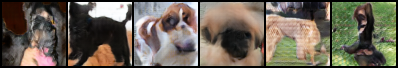

Generated breed(1.0):  gordon_setter


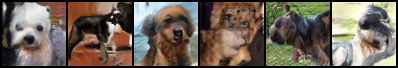

Generated breed(1.0):  great_dane


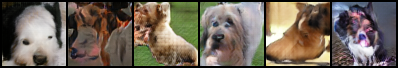

Generated breed(1.1):  greater_swiss_mountain_dog


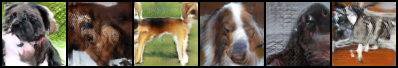

Generated breed(1.0):  italian_greyhound


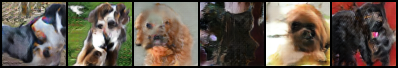

Generated breed(1.2):  japanese_spaniel


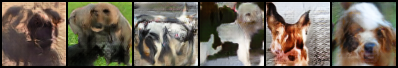

Generated breed(1.1):  kelpie


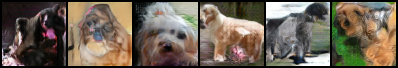

Generated breed(1.0):  kerry_blue_terrier


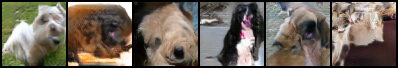

Generated breed(1.0):  komondor


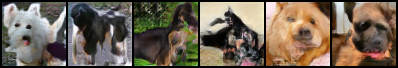

Generated breed(1.1):  kuvasz


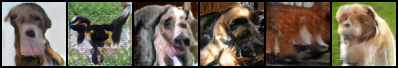

Generated breed(1.1):  lakeland_terrier


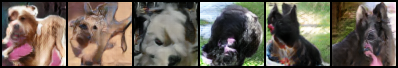

Generated breed(1.1):  lhasa


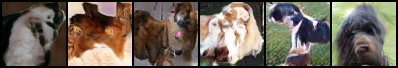

Generated breed(1.1):  maltese_dog


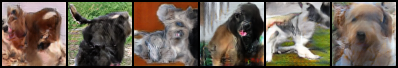

Generated breed(1.1):  miniature_pinscher


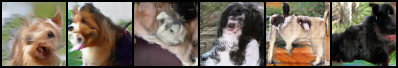

Generated breed(1.0):  miniature_schnauzer


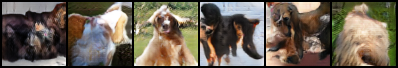

Generated breed(1.1):  newfoundland


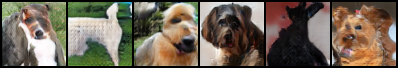

Generated breed(1.0):  norfolk_terrier


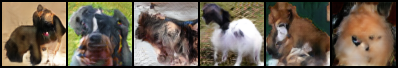

Generated breed(1.2):  old_english_sheepdog


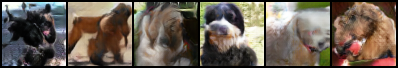

Generated breed(1.1):  otterhound


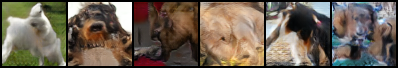

Generated breed(1.2):  papillon


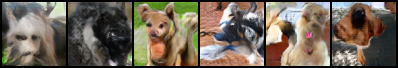

Generated breed(1.1):  pembroke


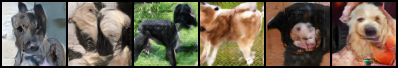

Generated breed(1.0):  pomeranian


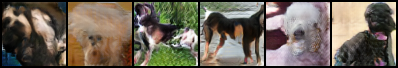

Generated breed(1.4):  rottweiler


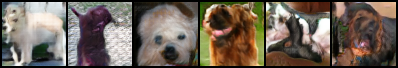

Generated breed(1.3):  saint_bernard


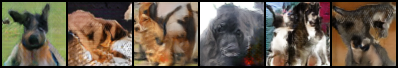

Generated breed(1.0):  saluki


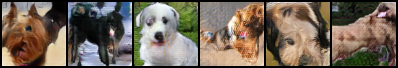

Generated breed(1.0):  scotch_terrier


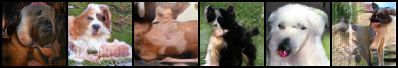

Generated breed(1.2):  sealyham_terrier


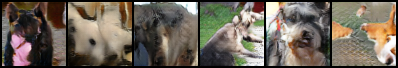

Generated breed(1.0):  shetland_sheepdog


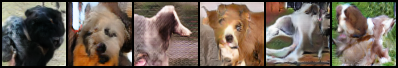

Generated breed(1.0):  shih


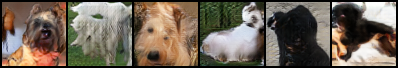

Generated breed(1.3):  siberian_husky


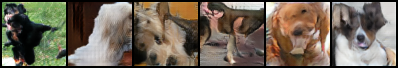

Generated breed(1.1):  staffordshire_bullterrier


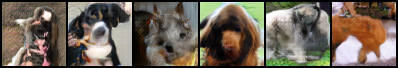

Generated breed(1.2):  standard_poodle


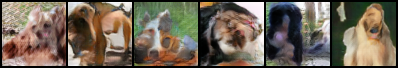

Generated breed(1.0):  standard_schnauzer


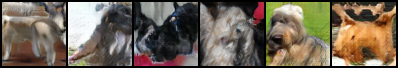

Generated breed(1.0):  tibetan_terrier


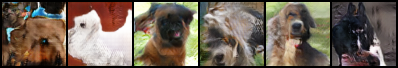

Generated breed(1.0):  toy_poodle


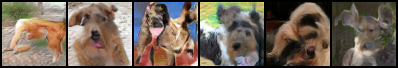

Generated breed(1.0):  toy_terrier


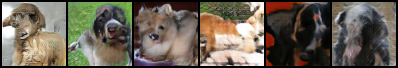

Generated breed(1.0):  walker_hound


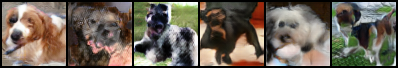

Generated breed(1.3):  weimaraner


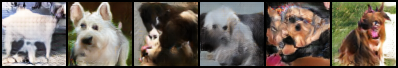

Generated breed(1.1):  welsh_springer_spaniel


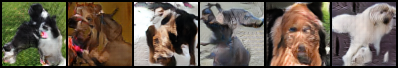

Generated breed(1.0):  yorkshire_terrier


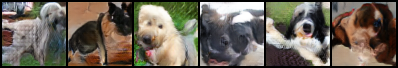

Creating submit


In [15]:
good_breeds = analyse_generated_by_class(6)
create_submit(good_breeds)

In [17]:
import numpy as np
import os
import gzip, pickle
import tensorflow as tf
from scipy import linalg
import pathlib
import urllib
import warnings
# from tqdm import tqdm
from PIL import Image

class KernelEvalException(Exception):
    pass

model_params = {
    'Inception': {
        'name': 'Inception', 
        'imsize': 64,
        'output_layer': 'Pretrained_Net/pool_3:0', 
        'input_layer': 'Pretrained_Net/ExpandDims:0',
        'output_shape': 2048,
        'cosine_distance_eps': 0.1
        }
}

def create_model_graph(pth):
    with tf.gfile.FastGFile( pth, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString( f.read())
        _ = tf.import_graph_def( graph_def, name='Pretrained_Net')

def _get_model_layer(sess, model_name):
    layername = model_params[model_name]['output_layer']
    layer = sess.graph.get_tensor_by_name(layername)
    ops = layer.graph.get_operations()
    for op_idx, op in enumerate(ops):
        for o in op.outputs:
            shape = o.get_shape()
            if shape._dims != []:
              shape = [s.value for s in shape]
              new_shape = []
              for j, s in enumerate(shape):
                if s == 1 and j == 0:
                  new_shape.append(None)
                else:
                  new_shape.append(s)
              o.__dict__['_shape_val'] = tf.TensorShape(new_shape)
    return layer

def get_activations(images, sess, model_name, batch_size=50, verbose=False):
    inception_layer = _get_model_layer(sess, model_name)
    n_images = images.shape[0]
    if batch_size > n_images:
        print("warning: batch size is bigger than the data size. setting batch size to data size")
        batch_size = n_images
    n_batches = n_images//batch_size + 1
    pred_arr = np.empty((n_images,model_params[model_name]['output_shape']))
    for i in tqdm(range(n_batches)):
        if verbose:
            print("\rPropagating batch %d/%d" % (i+1, n_batches), end="", flush=True)
        start = i*batch_size
        if start+batch_size < n_images:
            end = start+batch_size
        else:
            end = n_images
                    
        batch = images[start:end]
        pred = sess.run(inception_layer, {model_params[model_name]['input_layer']: batch})
        pred_arr[start:end] = pred.reshape(-1,model_params[model_name]['output_shape'])
    if verbose:
        print(" done")
    return pred_arr

def normalize_rows(x: np.ndarray):
    return np.nan_to_num(x/np.linalg.norm(x, ord=2, axis=1, keepdims=True))

def cosine_distance(features1, features2):
    features1_nozero = features1[np.sum(features1, axis=1) != 0]
    features2_nozero = features2[np.sum(features2, axis=1) != 0]
    norm_f1 = normalize_rows(features1_nozero)
    norm_f2 = normalize_rows(features2_nozero)

    d = 1.0-np.abs(np.matmul(norm_f1, norm_f2.T))
    print('d.shape=',d.shape)
    print('np.min(d, axis=1).shape=',np.min(d, axis=1).shape)
    mean_min_d = np.mean(np.min(d, axis=1))
    print('distance=',mean_min_d)
    return mean_min_d

def distance_thresholding(d, eps):
    if d < eps:
        return d
    else:
        return 1

def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, "Training and test mean vectors have different lengths"
    assert sigma1.shape == sigma2.shape, "Training and test covariances have different dimensions"

    diff = mu1 - mu2

    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = "fid calculation produces singular product; adding %s to diagonal of cov estimates" % eps
        warnings.warn(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError("Imaginary component {}".format(m))
        covmean = covmean.real

    print('covmean.shape=',covmean.shape)
    tr_covmean = np.trace(covmean)
    return diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * tr_covmean

def calculate_activation_statistics(images, sess, model_name, batch_size=50, verbose=False):
    act = get_activations(images, sess, model_name, batch_size, verbose)
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma, act
    
def _handle_path_memorization(path, sess, model_name, is_checksize, is_check_png):
    path = pathlib.Path(path)
    files = list(path.glob('*.jpg')) + list(path.glob('*.png'))
    imsize = model_params[model_name]['imsize']
    x = np.array([np.array(img_read_checks(fn, imsize, is_checksize, imsize, is_check_png)) for fn in files])
    m, s, features = calculate_activation_statistics(x, sess, model_name)
    del x 
    return m, s, features

def img_read_checks(filename, resize_to, is_checksize=False, check_imsize = 64, is_check_png = False):
    im = Image.open(str(filename))
    if is_checksize and im.size != (check_imsize,check_imsize):
        raise KernelEvalException('The images are not of size '+str(check_imsize))
    
    if is_check_png and im.format != 'PNG':
        raise KernelEvalException('Only PNG images should be submitted.')

    if resize_to is None:
        return im
    else:
        return im.resize((resize_to,resize_to),Image.ANTIALIAS)

def calculate_kid_given_paths(paths, model_name, model_path, feature_path=None, mm=[], ss=[], ff=[]):
    tf.reset_default_graph()
    create_model_graph(str(model_path))
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        m1, s1, features1 = _handle_path_memorization(paths[0], sess, model_name, is_checksize = True, is_check_png = True)
        if len(mm) != 0:
            m2 = mm
            s2 = ss
            features2 = ff
        elif feature_path is None:
            m2, s2, features2 = _handle_path_memorization(paths[1], sess, model_name, is_checksize = False, is_check_png = False)
        else:
            with np.load(feature_path) as f:
                m2, s2, features2 = f['m'], f['s'], f['features']

        print('m1,m2 shape=',(m1.shape,m2.shape),'s1,s2=',(s1.shape,s2.shape))
        print('starting calculating FID')
        fid_value = calculate_frechet_distance(m1, s1, m2, s2)
        print('done with FID, starting distance calculation')
        distance = cosine_distance(features1, features2)        
        return fid_value, distance, m2, s2, features2

In [18]:
if COMPUTE_LB:
    shutil.unpack_archive('images.zip', extract_dir='../tmp/images2')
    m2 = []; s2 =[]; f2 = []
    user_images_unzipped_path = '../tmp/images2/'
    images_path = [user_images_unzipped_path,'../input/generative-dog-images/all-dogs/all-dogs/']
    public_path = '../input/dog-face-generation-competition-kid-metric-input/classify_image_graph_def.pb'

    fid_epsilon = 10e-15

    fid_value_public, distance_public, m2, s2, f2 = calculate_kid_given_paths(images_path, 'Inception', public_path, mm=m2, ss=s2, ff=f2)
    distance_public = distance_thresholding(distance_public, model_params['Inception']['cosine_distance_eps'])
    print("FID_public: ", fid_value_public, "distance_public: ", distance_public, "multiplied_public: ",
            fid_value_public /(distance_public + fid_epsilon))

    ! rm -r ../tmp